In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Pre-Processing the Data

In [ ]:
import re
from string import punctuation
import timeit

In [ ]:
data = pd.read_csv('trump tweets alltime.csv',
                   error_bad_lines=False)

In [ ]:
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [ ]:
data['text'] = data['text'].apply(processTweet)

In [ ]:
df = pd.DataFrame(data)
df.to_csv('ttat.csv')

## Preparing the Data

In [3]:
path = Path()

In [4]:
path.ls();

In [5]:
bs=64

In [6]:
df = pd.read_csv(path/'ttat.csv') # about 97% of all Trump tweets)
df.head()

,sentiment,text,retweet_count
0,NaN,RT @ChatByCC: Strong people stand up for thems...,20709
1,NaN,The Media has a big responsibility to life and...,4749
2,NaN,We cannot let those killed in El Paso Texas an...,4687
3,NaN,....this legislation with desperately needed i...,4069
4,NaN,Today I authorized the lowering of the flags t...,20958


In [8]:
data_lm = TextLMDataBunch.from_csv(path, 'ttat.csv', max_vocab = 60000, min_freq=2)

In [9]:
data_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

In [10]:
data_lm.show_batch(3)

idx,text
0,turnberry . xxmaj just left xxmaj ireland property will be great . xxup always xxup checking ! xxbos xxunk : @realdonaldtrump xxmaj great xxmaj job xxmaj donald ! ! ! xxmaj ca n't xxunk for you to be xxmaj president and neither can xxmaj america ! ! xxbos xxunk : i 'm voting for @realdonaldtrump ! xxmaj calls it like it is ! # trump2016 xxmaj very nice xxmaj frank
1,"in the xxmaj house . xxbos xxunk : xxmaj without passion you do n't have energy without energy you have nothing ""- xxmaj donald xxmaj trump xxmaj lean from the best ! xxbos xxmaj monitoring the terrible situation in xxmaj florida . xxmaj just spoke to xxmaj governor xxmaj scott . xxmaj thoughts and prayers for all . xxmaj stay safe ! xxbos @beatsbyray : @realdonaldtrump you 're a legend"
2,xxbos xxmaj wow xxmaj huffington xxmaj post just stated that i am number 1 in the polls of xxmaj republican candidates . xxmaj thank you but the work has just begun ! xxbos xxup .@cnn is so negative it is impossible to watch . xxmaj terrible panel angry haters . xxmaj bill o @oreillyfactor said such an amazing thing about me ! xxbos xxmaj congrats to @trumpwaikiki for being named


In [11]:
# Classifier DataBunch
data_clas = TextClasDataBunch.from_csv(path, 'tr_ch_tw_train.csv', vocab=data_lm.train_ds.vocab, bs=8)

In [12]:
data_lm

TextLMDataBunch;

Train: LabelList (29591 items)
x: LMTextList
xxbos xxup rt @foxnews : xxunk : â€œi think full transparency is in order here.â€ # xxunk @mariabartiromo https : / / t.co / xxunk,xxbos â€œtrump : ' xxmaj never xxmaj give xxmaj up ' on xxmaj xxunk xxmaj value xxmaj xxunk http : / / t.co / xxunk @terrybranstad xxunk @chuckgrassley @senjoniernst xxunk,xxbos i am in xxmaj scotland checking on my developments in xxmaj aberdeen and xxmaj turnberry . xxmaj just left xxmaj ireland property will be great . xxup always xxup checking !,xxbos xxunk : @realdonaldtrump xxmaj great xxmaj job xxmaj donald ! ! ! xxmaj ca n't xxunk for you to be xxmaj president and neither can xxmaj america ! !,xxbos xxunk : i 'm voting for @realdonaldtrump ! xxmaj calls it like it is ! # trump2016 xxmaj very nice xxmaj frank - our xxmaj country does need leadership .
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (7398 items)
x: LMTextList
xxbos xxunk is whatever you think it is . xxmaj you are as old a

In [13]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

## The Language Model

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

In [14]:
learn.model;

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


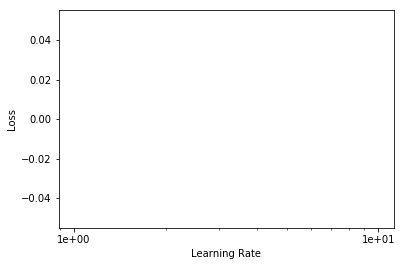

In [42]:
learn.recorder.plot(skip_end=15)

In [16]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [17]:
# Run one epoch with lower layers 
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.788482,4.433996,0.275984,00:44


In [ ]:
# torch.cuda.empty_cache()

In [18]:
# Run for many epochs with all layers unfrozen
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.956473,3.632204,0.358673,00:57
1,3.551436,3.368664,0.383309,00:58
2,3.282353,3.250520,0.395964,00:58
3,3.047367,3.208311,0.401922,00:58
4,2.918803,3.208212,0.402378,00:58


In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.918854,3.206630,0.402214,00:56
1,2.916834,3.199018,0.402720,00:57
2,2.871039,3.194228,0.404068,00:58
3,2.729848,3.201420,0.404382,00:58
4,2.538884,3.205028,0.406674,00:58
5,2.407159,3.227583,0.406678,00:58
6,2.228799,3.266782,0.407034,00:58
7,2.122553,3.294218,0.406696,00:58
8,2.040552,3.315276,0.405899,00:58
9,1.998733,3.321456,0.406104,00:58


In [22]:
learn.predict("I have spoken with", n_words=20)

'I have spoken with the " Family of America " at Trump International Hotel Las Vegas /'

In [23]:
learn.save_encoder('ft_enc')

## The Classifier

In [24]:
bs=8

In [25]:
# Classifier Learner Object
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [26]:
learn.load_encoder('ft_enc')

In [27]:
data_clas.show_batch()

text,target
xxbos xxmaj there will be nobody left in xxmaj china to do business with . xxmaj very bad for xxmaj china very good for xxup usa ! xxmaj but xxmaj china has taken so advantage of the xxup u.s. for so many years that they are way ahead ( xxmaj our xxmaj presidents did not do the job ) . xxmaj therefore xxmaj china should not retaliate - will only,negative
xxbos xxmaj very productive talks yesterday with xxmaj china on xxmaj trade . xxmaj will continue today ! i will be leaving for xxmaj hanoi xxmaj vietnam early tomorrow for a xxmaj summit with xxmaj kim xxmaj jong xxmaj un of xxmaj north xxmaj korea where we both expect a xxunk of the progress made at first xxmaj summit in xxmaj singapore . xxmaj denuclearization ?,positive
xxbos xxmaj china must continue to be strong and tight on the xxmaj border of xxmaj north xxmaj korea until a deal is made . xxmaj the word is that recently the xxmaj border has become much more porous and more has been xxunk in . i want this to happen and xxmaj north xxmaj korea to be xxup very successful but only after signing !,positive
xxbos xxmaj just had a long and very good conversation with xxmaj president xxmaj xi xxmaj jinping of xxmaj china . xxmaj we talked about many subjects with a heavy emphasis on xxmaj trade . xxmaj those discussions are moving along nicely with meetings being scheduled at the xxup g-20 in xxmaj argentina . xxmaj also had good discussion on xxmaj north xxmaj korea !,positive
xxbos xxmaj president xxmaj xi and i will always be friends no matter what happens with our xxunk on trade . xxmaj china will take down its xxmaj trade xxmaj barriers because it is the right thing to do . xxmaj taxes will become xxmaj reciprocal and a deal will be made on xxmaj intellectual xxmaj property . xxmaj great future for both countries !,positive


In [28]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.605477,0.578408,0.857143,00:01


In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.453403,0.565009,0.714286,00:01


In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.361255,0.471794,0.761905,00:01


In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.281951,0.438378,0.857143,00:01
1,0.289122,0.407874,0.857143,00:01


In [32]:
learn.predict("China has announced it is “fully prepared” for a currency war Outrageous - they have no fear of our leaders")

(Category negative, tensor(0), tensor([0.6533, 0.3467]))

In [33]:
test = pd.read_csv(path/'final_china - output.csv')

In [34]:
test.head(5)

,sentiment,text,created_at,retweet_count
0,NaN,china is intent on continuing to receive the h...,08-05-2019 16:00:14,14076.0
1,NaN,based on the historic currency manipulation by...,08-05-2019 15:58:59,15699.0
2,NaN,china dropped the price of their currency to a...,08-05-2019 12:12:44,21003.0
3,NaN,things are going along very well with china th...,08-03-2019 12:46:45,18501.0
4,NaN,we look forward to continuing our positive dia...,08-01-2019 17:26:11,13196.0


In [35]:
test_pred = test

In [36]:
test_pred['sentiment'] = test_pred['text'].apply(lambda row: str(learn.predict(row)[0]))

In [35]:
test_pred.head(20)

,Unnamed: 0,sentiment,text,created_at,retweet_count
0,0,negative,china is intent on continuing to receive the h...,08-05-2019 16:00:14,14076
1,1,negative,based on the historic currency manipulation by...,08-05-2019 15:58:59,15699
2,2,negative,china dropped the price of their currency to a...,08-05-2019 12:12:44,21003
3,3,negative,things are going along very well with china th...,08-03-2019 12:46:45,18501
4,4,positive,countries are coming to us wanting to negotiat...,08-03-2019 12:41:49,19014
5,5,positive,we look forward to continuing our positive dia...,08-01-2019 17:26:11,13196
6,6,positive,buy agricultural product from the u s in large...,08-01-2019 17:26:10,6660
7,7,positive,during the talks the u s will start on septemb...,08-01-2019 17:26:10,14686
8,8,positive,our representatives have just returned from ch...,08-01-2019 17:26:09,16938
9,9,negative,china iran other foreign countries are looking...,08-01-2019 14:24:26,20046


In [37]:
test_pred.to_csv('finalchinaoutput.csv')

## Word Cloud

In [ ]:
import matplotlib.pyplot as plt
import csv
from wordcloud import WordCloud, STOPWORDS
from pathlib import Path
from PIL import Image
from collections import Counter
from textblob import TextBlob

In [ ]:
text = data.text.values

In [ ]:
wordcloud = WordCloud(
    width = 1000,
    height = 800,
    max_words= 50, 
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (50, 40),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()